# Treinamento do modelo preliminar de classificação de áudio

In [1]:
!gdown 16MMIiaSZeozAFI7MEBU-eHY0-h7kTXpW

Downloading...
From (original): https://drive.google.com/uc?id=16MMIiaSZeozAFI7MEBU-eHY0-h7kTXpW
From (redirected): https://drive.google.com/uc?id=16MMIiaSZeozAFI7MEBU-eHY0-h7kTXpW&confirm=t&uuid=1ab94f72-45b3-43eb-afeb-ba778c57a459
To: /content/emoUERJ.zip
100% 105M/105M [00:04<00:00, 21.4MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import torchaudio
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import zipfile
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

A função responsável por extrair características de áudio começa carregando o arquivo de áudio e, se necessário, realiza a reamostragem para garantir que todos os arquivos tenham a mesma taxa de amostragem, o que é crucial para consistência dos dados. Em seguida, gera-se um espectrograma mel que representa a intensidade do som em várias frequências ao longo do tempo. Para garantir que todos os espectrogramas tenham o mesmo tamanho, o que facilita o treinamento do modelo, o espectrograma é padronizado para um comprimento máximo, truncando ou preenchendo com zeros conforme necessário. Essa padronização é importante para garantir que a entrada da rede neural tenha um formato consistente.

In [ ]:
def get_features(path, target_sample_rate=16000, n_fft=1024, hop_length=512, n_mels=64, max_pad_len=400):
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != target_sample_rate:
        resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resample_transform(waveform)
    mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_spectrogram = mel_spectrogram_transform(waveform)
    mel_spectrogram = mel_spectrogram.mean(dim=0)
    pad = max_pad_len - mel_spectrogram.shape[-1]
    if pad > 0:
        mel_spectrogram = torch.nn.functional.pad(mel_spectrogram, (0, pad))
    elif pad < 0:
        mel_spectrogram = mel_spectrogram[:, :max_pad_len]
    return mel_spectrogram.numpy()

In [ ]:
def load_and_split_data(df, audio_col, label_col, label_mapping):
    X, Y = [], []
    encoder = OneHotEncoder()
    max_pad_len = 400
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        path = row[audio_col]
        emotion = label_mapping[row[label_col]]
        features = get_features(path, max_pad_len=max_pad_len)
        X.append(features.flatten())
        Y.append(emotion)
    Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
    X = np.array(X)
    X_train, X_temp, y_train, y_temp = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test, encoder

Em seguida, os dados são escalonados usando o StandardScaler para normalizar os valores das características, o que melhora a convergência do modelo durante o treinamento. A normalização está sendo feita para que todas as características contribuam igualmente no aprendizado do modelo. Após a normalização, os dados são reestruturados para o formato esperado pela rede neural.

In [13]:
zip_path = 'emoUERJ.zip'
extract_to = 'emoUERJ'

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

audio_dir = os.path.join(extract_to, 'emoUERJ')
data = []
emotion_mapping = {'h': 'happy', 'a': 'angry', 's': 'sad', 'n': 'neutral'}

for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        label_key = filename[3]
        emotion = emotion_mapping.get(label_key, None)
        if emotion:
            data.append({'filename': os.path.join(audio_dir, filename), 'emotion': emotion})

df_emoUERJ = pd.DataFrame(data)
print(df_emoUERJ['emotion'].unique())

['happy' 'angry' 'neutral' 'sad']


In [14]:
emo_label_mapping = {'happy': 0, 'angry': 1, 'sad': 2, 'neutral': 3}

X_train, X_val, X_test, y_train, y_val, y_test, encoder = load_and_split_data(df_emoUERJ, 'filename', 'emotion', emo_label_mapping)

# ajudand dados para o scaler
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

100%|██████████| 377/377 [00:08<00:00, 43.26it/s]


In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# restaurando a forma dos dados
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_val = X_val.reshape(X_val.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)

A construção do modelo envolve a definição de uma rede neural convolucional que já é comprovadamente eficaz para a extração de padrões de dados estruturados em matrizes, como imagens e espectrogramas de áudio. A arquitetura do modelo inclui camadas convolucionais para a extração de características, camadas de normalização para estabilizar o aprendizado, camadas de pooling para reduzir a dimensionalidade, e camadas de dropout para evitar o overfitting. Para a prova de conceito foi escolhido uso de Adam como otimizador e a função de perda categórica cross-entropy por ser uma classificação multiclasse, ajustando o modelo para minimizar a perda enquanto melhora a acurácia.

In [7]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model((X_train.shape[1], 1), y_train.shape[1])
model.summary()

callbacks = [
    ModelCheckpoint('best_model_emoUERJ.h5', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.000001, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)


['happy' 'angry' 'neutral' 'sad']


100%|██████████| 377/377 [00:08<00:00, 45.02it/s]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 25600, 64)         256       
                                                                 
 batch_normalization_4 (Bat  (None, 25600, 64)         256       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 12800, 64)         0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 12800, 64)         0         
                                                                 
 conv1d_5 (Conv1D)           (None, 12800, 128)        24704     
                                                                 
 batch_normalization_5 (Bat  (None, 12800, 128)       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 100s 24s/step - loss: 380.1105 - accuracy: 0.2492 - val_loss: 4222.1362 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 84s 21s/step - loss: 47.8558 - accuracy: 0.7209 - val_loss: 622.0581 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 90s 22s/step - loss: 13.5545 - accuracy: 0.8339 - val_loss: 3070.3525 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 2s 330ms/step - loss: 3.3558 - accuracy: 0.9136 - val_loss: 5888.1943 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 83s 21s/step - loss: 1.8159 - accuracy: 0.9402 - val_loss: 7900.8765 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 2s 331ms/step - loss: 0.3577 - accuracy: 0.9767 - val_loss: 9385.9121 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 2s 328ms/step - loss: 0.3

Durante o treinamento, callbacks como ModelCheckpoint, EarlyStopping e ReduceLROnPlateau são utilizados para monitorar a performance do modelo na validação, salvar o melhor modelo baseado na acurácia de validação, parar o treinamento se o desempenho não melhorar, e reduzir a taxa de aprendizado quando necessário. Estes mecanismos garantem que o modelo seja treinado eficientemente e que o melhor desempenho seja alcançado. Apesar do dataset ser pequeno, quando utilizarmos mais dados essas estratégias serão ainda mais úteis e impactantes no desempenho do modelo.


2/2 [==============================] - 0s 39ms/step


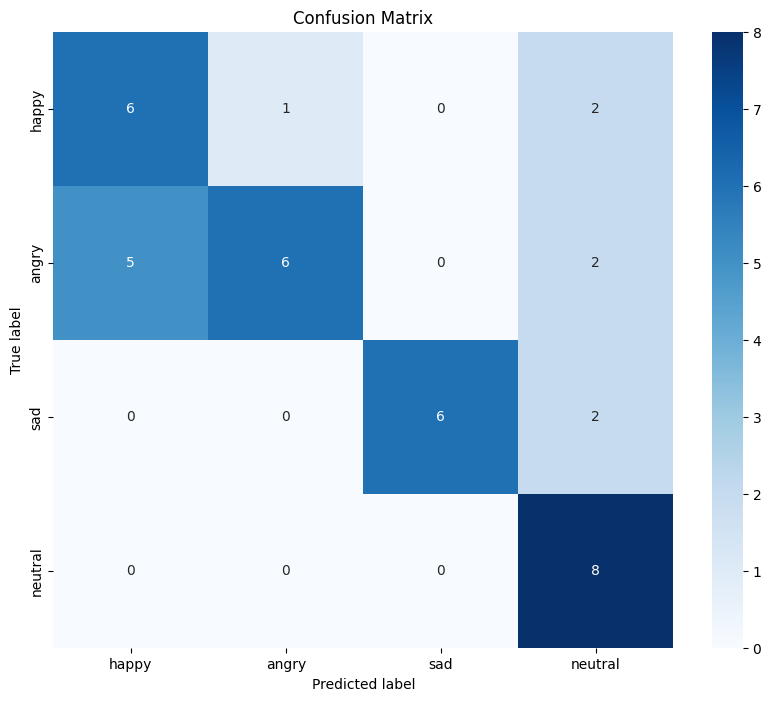

Classification Report:
              precision    recall  f1-score   support

       happy       0.55      0.67      0.60         9
       angry       0.86      0.46      0.60        13
         sad       1.00      0.75      0.86         8
     neutral       0.57      1.00      0.73         8

    accuracy                           0.68        38
   macro avg       0.74      0.72      0.70        38
weighted avg       0.75      0.68      0.68        38

Accuracy: 0.6842105263157895
F1 Score: 0.6809295967190705


In [8]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def evaluate_model(model, X_test, y_test, label_to_index):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    index_to_label = {v: k for k, v in label_to_index.items()}
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plot_confusion_matrix(cm, [index_to_label[i] for i in range(len(index_to_label))], title="Confusion Matrix")

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=[index_to_label[i] for i in range(len(index_to_label))]))

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

evaluate_model(model, X_test, y_test, emo_label_mapping)


Como resultados após o treinamento, a precisão para happy é de 55% corretas, enquanto o recall mostra que 67% das instâncias reais foram corretamente identificadas. A classe angry apresenta uma precisão de 0.86, mas um recall de 0.46, sugerindo que, embora a maioria das previsões angry esteja correta, muitas instâncias reais dessa classe não foram capturadas. Para sad, tanto a precisão quanto o recall são elevados, com 1.00 e 0.75, respectivamente, refletindo um bom desempenho do modelo nessa categoria. A classe neutral tem uma precisão de 0.57 e um recall de 1.00, o que significa que todas as instâncias reais foram identificadas, mas há uma quantidade considerável de previsões erradas.

A acurácia geral do modelo é de aproximadamente 68%, o que indica que o modelo está correto em 68% das previsões. O F1-score médio é também de 0.68, sugerindo um desempenho balanceado em termos de precisão e recall. Esses resultados indicam que o modelo possui um desempenho razoável, mas há espaço para melhorias, especialmente nas classes angry e neutral, onde a diferença entre precisão e recall é mais pronunciada.

In [9]:
def predict_emotion(audio_path, model, scaler):
    features = get_features(audio_path)
    features = features.flatten().reshape(1, -1)
    features = scaler.transform(features)
    features = features.reshape(features.shape[0], features.shape[1], 1)
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

In [10]:
emo_label_mapping = {'happy': 0, 'angry': 1, 'sad': 2, 'neutral': 3}
index_to_emotion = {v: k for k, v in emo_label_mapping.items()}

audio_path = '/content/Gravação233.m4a'
predicted_class = predict_emotion(audio_path, model, scaler)
predicted_emotion = index_to_emotion[predicted_class]
print(f'Predicted emotion: {predicted_emotion}')

1/1 [==============================] - 0s 208ms/step
Predicted emotion: sad
